<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:44:21] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


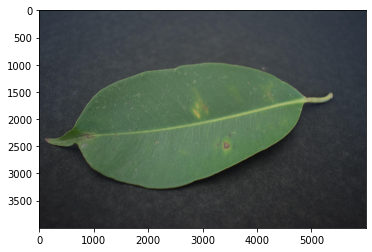

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

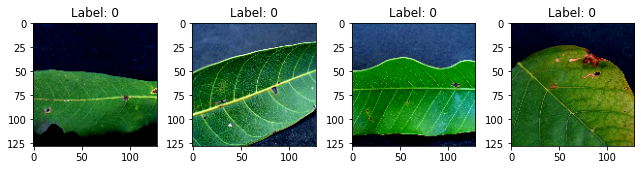

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:44:26] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:44:28] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2523906865195318 samples/sec                   batch loss = 1.8623517751693726 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2124336844819448 samples/sec                   batch loss = 0.48652932047843933 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2538097704280475 samples/sec                   batch loss = 1.2065718173980713 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2473362201790337 samples/sec                   batch loss = 0.8581278324127197 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.261142043117017 samples/sec                   batch loss = 1.1351194381713867 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2519238838287499 samples/sec                   batch loss = 0.4573420584201813 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.25797931547821 samples/sec                   batch loss = 1.2764121294021606 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2599426383146048 samples/sec                   batch loss = 0.5270628929138184 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2604731104660445 samples/sec                   batch loss = 0.4806654751300812 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2638283162147077 samples/sec                   batch loss = 1.1983927488327026 | accuracy = 0.62


Epoch[1] Batch[55] Speed: 1.2581895068331101 samples/sec                   batch loss = 0.3714805245399475 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.263519549130335 samples/sec                   batch loss = 0.5214475989341736 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.261853823446081 samples/sec                   batch loss = 0.4509318470954895 | accuracy = 0.6384615384615384


Epoch[1] Batch[70] Speed: 1.26177657388563 samples/sec                   batch loss = 0.8014724254608154 | accuracy = 0.6428571428571429


Epoch[1] Batch[75] Speed: 1.2561870552777334 samples/sec                   batch loss = 0.7437141537666321 | accuracy = 0.6333333333333333


Epoch[1] Batch[80] Speed: 1.2636744848975257 samples/sec                   batch loss = 0.7562696933746338 | accuracy = 0.6375


Epoch[1] Batch[85] Speed: 1.2629336493750791 samples/sec                   batch loss = 0.9730706810951233 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.2647691579114488 samples/sec                   batch loss = 0.33068907260894775 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.2593365122720115 samples/sec                   batch loss = 0.4532220959663391 | accuracy = 0.6368421052631579


Epoch[1] Batch[100] Speed: 1.2657437727596315 samples/sec                   batch loss = 0.2874657213687897 | accuracy = 0.6375


Epoch[1] Batch[105] Speed: 1.2589723040164729 samples/sec                   batch loss = 1.7303085327148438 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.2618828656534378 samples/sec                   batch loss = 0.6625992059707642 | accuracy = 0.6409090909090909


Epoch[1] Batch[115] Speed: 1.2580028971860373 samples/sec                   batch loss = 0.48825886845588684 | accuracy = 0.6521739130434783


Epoch[1] Batch[120] Speed: 1.2681866064528302 samples/sec                   batch loss = 0.6529975533485413 | accuracy = 0.65


Epoch[1] Batch[125] Speed: 1.2642981332908916 samples/sec                   batch loss = 1.1515322923660278 | accuracy = 0.644


Epoch[1] Batch[130] Speed: 1.2596870277032222 samples/sec                   batch loss = 0.3158276677131653 | accuracy = 0.6442307692307693


Epoch[1] Batch[135] Speed: 1.2594966642573606 samples/sec                   batch loss = 0.42590388655662537 | accuracy = 0.6462962962962963


Epoch[1] Batch[140] Speed: 1.2608954218819695 samples/sec                   batch loss = 0.5608569383621216 | accuracy = 0.65


Epoch[1] Batch[145] Speed: 1.267226222007441 samples/sec                   batch loss = 0.5638864636421204 | accuracy = 0.653448275862069


Epoch[1] Batch[150] Speed: 1.2631026104637786 samples/sec                   batch loss = 0.294267863035202 | accuracy = 0.655


Epoch[1] Batch[155] Speed: 1.2650092848088343 samples/sec                   batch loss = 0.731016218662262 | accuracy = 0.6548387096774193


Epoch[1] Batch[160] Speed: 1.256779420035639 samples/sec                   batch loss = 0.3094733655452728 | accuracy = 0.6578125


Epoch[1] Batch[165] Speed: 1.2584049598083666 samples/sec                   batch loss = 1.257257342338562 | accuracy = 0.6515151515151515


Epoch[1] Batch[170] Speed: 1.259187458153027 samples/sec                   batch loss = 0.32674580812454224 | accuracy = 0.6544117647058824


Epoch[1] Batch[175] Speed: 1.265153328395551 samples/sec                   batch loss = 0.6279886960983276 | accuracy = 0.6528571428571428


Epoch[1] Batch[180] Speed: 1.2621561746379764 samples/sec                   batch loss = 0.5868643522262573 | accuracy = 0.6555555555555556


Epoch[1] Batch[185] Speed: 1.2664322698820967 samples/sec                   batch loss = 1.484717845916748 | accuracy = 0.6567567567567567


Epoch[1] Batch[190] Speed: 1.2580326113967275 samples/sec                   batch loss = 0.3981300890445709 | accuracy = 0.6618421052631579


Epoch[1] Batch[195] Speed: 1.2622651894960906 samples/sec                   batch loss = 0.876724898815155 | accuracy = 0.6628205128205128


Epoch[1] Batch[200] Speed: 1.2603019171862269 samples/sec                   batch loss = 0.783180296421051 | accuracy = 0.66625


Epoch[1] Batch[205] Speed: 1.2596418194498595 samples/sec                   batch loss = 1.0651425123214722 | accuracy = 0.6670731707317074


Epoch[1] Batch[210] Speed: 1.2596229048255543 samples/sec                   batch loss = 0.7995201349258423 | accuracy = 0.6666666666666666


Epoch[1] Batch[215] Speed: 1.261159960562291 samples/sec                   batch loss = 0.68819260597229 | accuracy = 0.6662790697674419


Epoch[1] Batch[220] Speed: 1.259332163966735 samples/sec                   batch loss = 0.40437352657318115 | accuracy = 0.6670454545454545


Epoch[1] Batch[225] Speed: 1.2635783593395253 samples/sec                   batch loss = 0.3185538649559021 | accuracy = 0.6666666666666666


Epoch[1] Batch[230] Speed: 1.2611939956301923 samples/sec                   batch loss = 0.25353315472602844 | accuracy = 0.6695652173913044


Epoch[1] Batch[235] Speed: 1.2593006869131467 samples/sec                   batch loss = 0.8477751612663269 | accuracy = 0.6702127659574468


Epoch[1] Batch[240] Speed: 1.259547346568733 samples/sec                   batch loss = 1.020041823387146 | accuracy = 0.66875


Epoch[1] Batch[245] Speed: 1.263627943073379 samples/sec                   batch loss = 0.5473516583442688 | accuracy = 0.6704081632653062


Epoch[1] Batch[250] Speed: 1.2594561024355453 samples/sec                   batch loss = 0.4454856514930725 | accuracy = 0.669


Epoch[1] Batch[255] Speed: 1.2619955354953394 samples/sec                   batch loss = 1.5100576877593994 | accuracy = 0.6696078431372549


Epoch[1] Batch[260] Speed: 1.2577179007378962 samples/sec                   batch loss = 0.390655517578125 | accuracy = 0.6711538461538461


Epoch[1] Batch[265] Speed: 1.2581526144895139 samples/sec                   batch loss = 0.7419102191925049 | accuracy = 0.6745283018867925


Epoch[1] Batch[270] Speed: 1.2565954872197713 samples/sec                   batch loss = 0.7828462719917297 | accuracy = 0.674074074074074


Epoch[1] Batch[275] Speed: 1.2616211544154932 samples/sec                   batch loss = 1.3307231664657593 | accuracy = 0.6709090909090909


Epoch[1] Batch[280] Speed: 1.265717417230374 samples/sec                   batch loss = 1.0273991823196411 | accuracy = 0.6732142857142858


Epoch[1] Batch[285] Speed: 1.2652077109936892 samples/sec                   batch loss = 0.6238874197006226 | accuracy = 0.6736842105263158


Epoch[1] Batch[290] Speed: 1.2597282665132317 samples/sec                   batch loss = 0.8995772004127502 | accuracy = 0.6724137931034483


Epoch[1] Batch[295] Speed: 1.2620836351151576 samples/sec                   batch loss = 0.39438754320144653 | accuracy = 0.6728813559322034


Epoch[1] Batch[300] Speed: 1.2577074350940012 samples/sec                   batch loss = 0.685676097869873 | accuracy = 0.6708333333333333


Epoch[1] Batch[305] Speed: 1.2614299214663405 samples/sec                   batch loss = 0.42335718870162964 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.2608005713772121 samples/sec                   batch loss = 0.3477313220500946 | accuracy = 0.6701612903225806


Epoch[1] Batch[315] Speed: 1.252384983726371 samples/sec                   batch loss = 0.5359631776809692 | accuracy = 0.6722222222222223


Epoch[1] Batch[320] Speed: 1.260399628007722 samples/sec                   batch loss = 0.6588374376296997 | accuracy = 0.6703125


Epoch[1] Batch[325] Speed: 1.256471922891048 samples/sec                   batch loss = 0.5974463224411011 | accuracy = 0.67


Epoch[1] Batch[330] Speed: 1.2566497013276408 samples/sec                   batch loss = 0.6414676904678345 | accuracy = 0.6704545454545454


Epoch[1] Batch[335] Speed: 1.2610428901645558 samples/sec                   batch loss = 0.34473860263824463 | accuracy = 0.6701492537313433


Epoch[1] Batch[340] Speed: 1.2558638663191783 samples/sec                   batch loss = 0.31825533509254456 | accuracy = 0.6713235294117647


Epoch[1] Batch[345] Speed: 1.2564941306819455 samples/sec                   batch loss = 0.20258165895938873 | accuracy = 0.672463768115942


Epoch[1] Batch[350] Speed: 1.2641244707672437 samples/sec                   batch loss = 0.3830370306968689 | accuracy = 0.6735714285714286


Epoch[1] Batch[355] Speed: 1.2666582057776297 samples/sec                   batch loss = 0.7137585282325745 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.2594602625021611 samples/sec                   batch loss = 0.5117990374565125 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.2640474191372673 samples/sec                   batch loss = 0.5754245519638062 | accuracy = 0.6753424657534246


Epoch[1] Batch[370] Speed: 1.2666136432698096 samples/sec                   batch loss = 0.23022416234016418 | accuracy = 0.677027027027027


Epoch[1] Batch[375] Speed: 1.2619506360030475 samples/sec                   batch loss = 0.5970829725265503 | accuracy = 0.6766666666666666


Epoch[1] Batch[380] Speed: 1.261927855241431 samples/sec                   batch loss = 0.43400585651397705 | accuracy = 0.675


Epoch[1] Batch[385] Speed: 1.2595714599211503 samples/sec                   batch loss = 0.5918259024620056 | accuracy = 0.675974025974026


Epoch[1] Batch[390] Speed: 1.2630071423688911 samples/sec                   batch loss = 1.0184696912765503 | accuracy = 0.6743589743589744


Epoch[1] Batch[395] Speed: 1.264675439704056 samples/sec                   batch loss = 0.3463188409805298 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.265293206073088 samples/sec                   batch loss = 0.36100056767463684 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.2603480249593324 samples/sec                   batch loss = 0.6132569909095764 | accuracy = 0.6759259259259259


Epoch[1] Batch[410] Speed: 1.2546192118562196 samples/sec                   batch loss = 0.4715413451194763 | accuracy = 0.676219512195122


Epoch[1] Batch[415] Speed: 1.2621657649109796 samples/sec                   batch loss = 0.5743503570556641 | accuracy = 0.6771084337349398


Epoch[1] Batch[420] Speed: 1.2549307777366463 samples/sec                   batch loss = 0.7956864237785339 | accuracy = 0.674404761904762


Epoch[1] Batch[425] Speed: 1.2581741268974922 samples/sec                   batch loss = 0.5628167390823364 | accuracy = 0.6741176470588235


Epoch[1] Batch[430] Speed: 1.257394960307167 samples/sec                   batch loss = 0.5714858770370483 | accuracy = 0.6744186046511628


Epoch[1] Batch[435] Speed: 1.2594160159292267 samples/sec                   batch loss = 0.3447854220867157 | accuracy = 0.6764367816091954


Epoch[1] Batch[440] Speed: 1.2699644593171513 samples/sec                   batch loss = 0.3744032084941864 | accuracy = 0.6767045454545455


Epoch[1] Batch[445] Speed: 1.260279953273264 samples/sec                   batch loss = 0.32676512002944946 | accuracy = 0.6775280898876405


Epoch[1] Batch[450] Speed: 1.2628758497693138 samples/sec                   batch loss = 0.3791479170322418 | accuracy = 0.6783333333333333


Epoch[1] Batch[455] Speed: 1.2601837754986382 samples/sec                   batch loss = 0.4675730764865875 | accuracy = 0.6791208791208792


Epoch[1] Batch[460] Speed: 1.2643260494912805 samples/sec                   batch loss = 0.3059736490249634 | accuracy = 0.6798913043478261


Epoch[1] Batch[465] Speed: 1.267205356077326 samples/sec                   batch loss = 0.9728555679321289 | accuracy = 0.6801075268817204


Epoch[1] Batch[470] Speed: 1.2617858737004477 samples/sec                   batch loss = 0.5855704545974731 | accuracy = 0.6808510638297872


Epoch[1] Batch[475] Speed: 1.2605667751424872 samples/sec                   batch loss = 0.386609822511673 | accuracy = 0.6815789473684211


Epoch[1] Batch[480] Speed: 1.2666428093635385 samples/sec                   batch loss = 0.5002785325050354 | accuracy = 0.6822916666666666


Epoch[1] Batch[485] Speed: 1.2598159552506398 samples/sec                   batch loss = 0.9009706377983093 | accuracy = 0.6835051546391753


Epoch[1] Batch[490] Speed: 1.2611983568023062 samples/sec                   batch loss = 0.4353611469268799 | accuracy = 0.6826530612244898


Epoch[1] Batch[495] Speed: 1.2603934732937803 samples/sec                   batch loss = 0.5569226741790771 | accuracy = 0.6828282828282828


Epoch[1] Batch[500] Speed: 1.2593326366071582 samples/sec                   batch loss = 0.6746446490287781 | accuracy = 0.682


Epoch[1] Batch[505] Speed: 1.26608057079976 samples/sec                   batch loss = 1.1937693357467651 | accuracy = 0.6816831683168317


Epoch[1] Batch[510] Speed: 1.2633493348996043 samples/sec                   batch loss = 0.12196449190378189 | accuracy = 0.682843137254902


Epoch[1] Batch[515] Speed: 1.26588473617844 samples/sec                   batch loss = 0.2810814678668976 | accuracy = 0.6839805825242719


Epoch[1] Batch[520] Speed: 1.2638913445613331 samples/sec                   batch loss = 0.35335269570350647 | accuracy = 0.6826923076923077


Epoch[1] Batch[525] Speed: 1.2680974610713378 samples/sec                   batch loss = 0.35387834906578064 | accuracy = 0.6823809523809524


Epoch[1] Batch[530] Speed: 1.257407117055998 samples/sec                   batch loss = 0.49670958518981934 | accuracy = 0.6839622641509434


Epoch[1] Batch[535] Speed: 1.2649943099739789 samples/sec                   batch loss = 0.3649035394191742 | accuracy = 0.685981308411215


Epoch[1] Batch[540] Speed: 1.2608834818724686 samples/sec                   batch loss = 0.7714833617210388 | accuracy = 0.6856481481481481


Epoch[1] Batch[545] Speed: 1.260675989251968 samples/sec                   batch loss = 1.9824490547180176 | accuracy = 0.6857798165137615


Epoch[1] Batch[550] Speed: 1.2588149299516063 samples/sec                   batch loss = 0.34280720353126526 | accuracy = 0.6854545454545454


Epoch[1] Batch[555] Speed: 1.2555005361831988 samples/sec                   batch loss = 0.6082260012626648 | accuracy = 0.6846846846846847


Epoch[1] Batch[560] Speed: 1.262013097476751 samples/sec                   batch loss = 0.3167330026626587 | accuracy = 0.6848214285714286


Epoch[1] Batch[565] Speed: 1.2590458091056875 samples/sec                   batch loss = 0.6520625948905945 | accuracy = 0.6853982300884955


Epoch[1] Batch[570] Speed: 1.2585821527291572 samples/sec                   batch loss = 0.29717370867729187 | accuracy = 0.6864035087719298


Epoch[1] Batch[575] Speed: 1.2611104755235567 samples/sec                   batch loss = 0.7901833653450012 | accuracy = 0.6852173913043478


Epoch[1] Batch[580] Speed: 1.2613048356438037 samples/sec                   batch loss = 0.5217043161392212 | accuracy = 0.6849137931034482


Epoch[1] Batch[585] Speed: 1.270415377393773 samples/sec                   batch loss = 0.40145617723464966 | accuracy = 0.6863247863247863


Epoch[1] Batch[590] Speed: 1.2582830211603624 samples/sec                   batch loss = 0.24894195795059204 | accuracy = 0.6864406779661016


Epoch[1] Batch[595] Speed: 1.2631060338905875 samples/sec                   batch loss = 0.40890154242515564 | accuracy = 0.6857142857142857


Epoch[1] Batch[600] Speed: 1.2629406845566784 samples/sec                   batch loss = 0.37462347745895386 | accuracy = 0.6866666666666666


Epoch[1] Batch[605] Speed: 1.2627487662824153 samples/sec                   batch loss = 0.42785903811454773 | accuracy = 0.687603305785124


Epoch[1] Batch[610] Speed: 1.2634640746142858 samples/sec                   batch loss = 0.6178514957427979 | accuracy = 0.6877049180327869


Epoch[1] Batch[615] Speed: 1.262805508702648 samples/sec                   batch loss = 1.0198395252227783 | accuracy = 0.6869918699186992


Epoch[1] Batch[620] Speed: 1.2608606448651385 samples/sec                   batch loss = 0.6394473314285278 | accuracy = 0.6870967741935484


Epoch[1] Batch[625] Speed: 1.2573164654101907 samples/sec                   batch loss = 0.6565232872962952 | accuracy = 0.688


Epoch[1] Batch[630] Speed: 1.2543123956497595 samples/sec                   batch loss = 0.4366876184940338 | accuracy = 0.6880952380952381


Epoch[1] Batch[635] Speed: 1.2601034177302086 samples/sec                   batch loss = 0.28477221727371216 | accuracy = 0.6885826771653544


Epoch[1] Batch[640] Speed: 1.2541533717804847 samples/sec                   batch loss = 0.7323709726333618 | accuracy = 0.68828125


Epoch[1] Batch[645] Speed: 1.2583604098225403 samples/sec                   batch loss = 1.0659122467041016 | accuracy = 0.6875968992248062


Epoch[1] Batch[650] Speed: 1.2589487804217339 samples/sec                   batch loss = 0.2561276853084564 | accuracy = 0.6876923076923077


Epoch[1] Batch[655] Speed: 1.2590682969528793 samples/sec                   batch loss = 0.39544981718063354 | accuracy = 0.6877862595419847


Epoch[1] Batch[660] Speed: 1.2632499296927677 samples/sec                   batch loss = 0.24754095077514648 | accuracy = 0.6890151515151515


Epoch[1] Batch[665] Speed: 1.24973684502606 samples/sec                   batch loss = 0.5233767628669739 | accuracy = 0.6883458646616541


Epoch[1] Batch[670] Speed: 1.2549716118409389 samples/sec                   batch loss = 0.6049038767814636 | accuracy = 0.6884328358208955


Epoch[1] Batch[675] Speed: 1.2562644685329158 samples/sec                   batch loss = 1.9958503246307373 | accuracy = 0.6888888888888889


Epoch[1] Batch[680] Speed: 1.2599260800815137 samples/sec                   batch loss = 0.5220152735710144 | accuracy = 0.6889705882352941


Epoch[1] Batch[685] Speed: 1.2543273999833127 samples/sec                   batch loss = 0.7029685378074646 | accuracy = 0.6886861313868613


Epoch[1] Batch[690] Speed: 1.2569881746334706 samples/sec                   batch loss = 0.35235103964805603 | accuracy = 0.6894927536231884


Epoch[1] Batch[695] Speed: 1.2624087987789774 samples/sec                   batch loss = 0.3147687613964081 | accuracy = 0.6899280575539568


Epoch[1] Batch[700] Speed: 1.2559603260289391 samples/sec                   batch loss = 0.27245643734931946 | accuracy = 0.6910714285714286


Epoch[1] Batch[705] Speed: 1.2625381890873615 samples/sec                   batch loss = 0.6072037220001221 | accuracy = 0.6900709219858157


Epoch[1] Batch[710] Speed: 1.2610608995802706 samples/sec                   batch loss = 0.7931222915649414 | accuracy = 0.6904929577464789


Epoch[1] Batch[715] Speed: 1.2635984398070335 samples/sec                   batch loss = 0.6813423037528992 | accuracy = 0.6909090909090909


Epoch[1] Batch[720] Speed: 1.258040346754857 samples/sec                   batch loss = 0.8900961875915527 | accuracy = 0.690625


Epoch[1] Batch[725] Speed: 1.2659820727414561 samples/sec                   batch loss = 0.46442297101020813 | accuracy = 0.6896551724137931


Epoch[1] Batch[730] Speed: 1.2640361812419356 samples/sec                   batch loss = 0.48263683915138245 | accuracy = 0.6904109589041096


Epoch[1] Batch[735] Speed: 1.2583275656666477 samples/sec                   batch loss = 0.4088969826698303 | accuracy = 0.691156462585034


Epoch[1] Batch[740] Speed: 1.2635645603361068 samples/sec                   batch loss = 0.7691782712936401 | accuracy = 0.6912162162162162


Epoch[1] Batch[745] Speed: 1.261331102556995 samples/sec                   batch loss = 0.354303240776062 | accuracy = 0.6926174496644295


Epoch[1] Batch[750] Speed: 1.2565510652572784 samples/sec                   batch loss = 0.4465395212173462 | accuracy = 0.6933333333333334


Epoch[1] Batch[755] Speed: 1.2639557123214469 samples/sec                   batch loss = 0.24153122305870056 | accuracy = 0.6927152317880795


Epoch[1] Batch[760] Speed: 1.2587442850053876 samples/sec                   batch loss = 0.3837040960788727 | accuracy = 0.6927631578947369


Epoch[1] Batch[765] Speed: 1.255424720122163 samples/sec                   batch loss = 0.5914633274078369 | accuracy = 0.6931372549019608


Epoch[1] Batch[770] Speed: 1.2643578735578522 samples/sec                   batch loss = 0.5845447778701782 | accuracy = 0.6928571428571428


Epoch[1] Batch[775] Speed: 1.262194156771569 samples/sec                   batch loss = 0.340313583612442 | accuracy = 0.694516129032258


Epoch[1] Batch[780] Speed: 1.2644432538182084 samples/sec                   batch loss = 0.8212107419967651 | accuracy = 0.6942307692307692


Epoch[1] Batch[785] Speed: 1.2637052291278912 samples/sec                   batch loss = 0.2613464295864105 | accuracy = 0.6949044585987261


[Epoch 1] training: accuracy=0.6951142131979695
[Epoch 1] time cost: 651.7584342956543
[Epoch 1] validation: validation accuracy=0.7222222222222222


Epoch[2] Batch[5] Speed: 1.2646905023244994 samples/sec                   batch loss = 0.8020466566085815 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.267849453638508 samples/sec                   batch loss = 0.5635796189308167 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2672250734062604 samples/sec                   batch loss = 0.8840359449386597 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2625876912191418 samples/sec                   batch loss = 0.9599815607070923 | accuracy = 0.6625


Epoch[2] Batch[25] Speed: 1.2640341812984568 samples/sec                   batch loss = 0.36092936992645264 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2654460954962405 samples/sec                   batch loss = 0.8154176473617554 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2647034679053872 samples/sec                   batch loss = 0.24076400697231293 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2632865508436737 samples/sec                   batch loss = 0.2794562578201294 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2711837040241762 samples/sec                   batch loss = 0.28837478160858154 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.260937308465247 samples/sec                   batch loss = 0.9738730192184448 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.260596610596374 samples/sec                   batch loss = 1.042313575744629 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2607527251393802 samples/sec                   batch loss = 0.38327187299728394 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.262918153238018 samples/sec                   batch loss = 0.5417636632919312 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2652951145772309 samples/sec                   batch loss = 0.23931261897087097 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.264887588775464 samples/sec                   batch loss = 0.24310331046581268 | accuracy = 0.76


Epoch[2] Batch[80] Speed: 1.2672950461615928 samples/sec                   batch loss = 0.0788358822464943 | accuracy = 0.759375


Epoch[2] Batch[85] Speed: 1.2605318268354957 samples/sec                   batch loss = 0.18443424999713898 | accuracy = 0.7647058823529411


Epoch[2] Batch[90] Speed: 1.2601147750967814 samples/sec                   batch loss = 0.5152978897094727 | accuracy = 0.7611111111111111


Epoch[2] Batch[95] Speed: 1.2644981472178873 samples/sec                   batch loss = 0.29605090618133545 | accuracy = 0.7657894736842106


Epoch[2] Batch[100] Speed: 1.2632051311203145 samples/sec                   batch loss = 0.1105230450630188 | accuracy = 0.7725


Epoch[2] Batch[105] Speed: 1.264452402387182 samples/sec                   batch loss = 0.30674734711647034 | accuracy = 0.7738095238095238


Epoch[2] Batch[110] Speed: 1.26016380341187 samples/sec                   batch loss = 0.44503316283226013 | accuracy = 0.7704545454545455


Epoch[2] Batch[115] Speed: 1.2642120105301167 samples/sec                   batch loss = 1.1044254302978516 | accuracy = 0.7695652173913043


Epoch[2] Batch[120] Speed: 1.2642715521161865 samples/sec                   batch loss = 0.49861299991607666 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2625913018911985 samples/sec                   batch loss = 0.6659733653068542 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.2611445079205577 samples/sec                   batch loss = 0.5063161849975586 | accuracy = 0.7557692307692307


Epoch[2] Batch[135] Speed: 1.2620380648106162 samples/sec                   batch loss = 0.27118322253227234 | accuracy = 0.7574074074074074


Epoch[2] Batch[140] Speed: 1.2736019652252004 samples/sec                   batch loss = 0.2897258698940277 | accuracy = 0.7642857142857142


Epoch[2] Batch[145] Speed: 1.2666124957788305 samples/sec                   batch loss = 0.5138549208641052 | accuracy = 0.7603448275862069


Epoch[2] Batch[150] Speed: 1.2588578119011367 samples/sec                   batch loss = 0.6410452127456665 | accuracy = 0.7616666666666667


Epoch[2] Batch[155] Speed: 1.2628033225518098 samples/sec                   batch loss = 1.1520081758499146 | accuracy = 0.7548387096774194


Epoch[2] Batch[160] Speed: 1.2565949225140982 samples/sec                   batch loss = 0.5266927480697632 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.26409627773383 samples/sec                   batch loss = 0.9393218755722046 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.2608081513124652 samples/sec                   batch loss = 0.14084942638874054 | accuracy = 0.7455882352941177


Epoch[2] Batch[175] Speed: 1.2619641150076268 samples/sec                   batch loss = 0.3382580876350403 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.262130253144245 samples/sec                   batch loss = 0.8726625442504883 | accuracy = 0.7416666666666667


Epoch[2] Batch[185] Speed: 1.266984678722287 samples/sec                   batch loss = 0.5926669836044312 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2607529146222687 samples/sec                   batch loss = 0.5553447604179382 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.2621598777954277 samples/sec                   batch loss = 0.5365480780601501 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.2581229889563765 samples/sec                   batch loss = 0.20960542559623718 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.2682632048070162 samples/sec                   batch loss = 0.4110301733016968 | accuracy = 0.7390243902439024


Epoch[2] Batch[210] Speed: 1.261681306127532 samples/sec                   batch loss = 0.25121715664863586 | accuracy = 0.7416666666666667


Epoch[2] Batch[215] Speed: 1.2625933922897228 samples/sec                   batch loss = 0.3123852014541626 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.2557957141517306 samples/sec                   batch loss = 0.4726276993751526 | accuracy = 0.7443181818181818


Epoch[2] Batch[225] Speed: 1.2625405643409164 samples/sec                   batch loss = 0.34177321195602417 | accuracy = 0.7444444444444445


Epoch[2] Batch[230] Speed: 1.266242633931907 samples/sec                   batch loss = 0.17350967228412628 | accuracy = 0.7445652173913043


Epoch[2] Batch[235] Speed: 1.2631805931217965 samples/sec                   batch loss = 0.5814820528030396 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2638483094203135 samples/sec                   batch loss = 0.3963177502155304 | accuracy = 0.7510416666666667


Epoch[2] Batch[245] Speed: 1.2686480621852618 samples/sec                   batch loss = 0.4866911768913269 | accuracy = 0.7520408163265306


Epoch[2] Batch[250] Speed: 1.2629925001328697 samples/sec                   batch loss = 0.5219257473945618 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.262260536038139 samples/sec                   batch loss = 0.9020408391952515 | accuracy = 0.7490196078431373


Epoch[2] Batch[260] Speed: 1.2638545931298633 samples/sec                   batch loss = 0.8097730278968811 | accuracy = 0.7471153846153846


Epoch[2] Batch[265] Speed: 1.2647764042516203 samples/sec                   batch loss = 0.5106971859931946 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2683663731577002 samples/sec                   batch loss = 0.5653043389320374 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.2581864874295836 samples/sec                   batch loss = 0.33220598101615906 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.2717646562982203 samples/sec                   batch loss = 0.3473854959011078 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.2654107806753134 samples/sec                   batch loss = 0.6144080758094788 | accuracy = 0.743859649122807


Epoch[2] Batch[290] Speed: 1.265278510784028 samples/sec                   batch loss = 0.6583107709884644 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2656751169906455 samples/sec                   batch loss = 0.27131548523902893 | accuracy = 0.7449152542372881


Epoch[2] Batch[300] Speed: 1.2691121579031455 samples/sec                   batch loss = 0.5178262591362 | accuracy = 0.7433333333333333


Epoch[2] Batch[305] Speed: 1.2685027422125164 samples/sec                   batch loss = 0.7310237288475037 | accuracy = 0.7426229508196721


Epoch[2] Batch[310] Speed: 1.2647530446368325 samples/sec                   batch loss = 0.44776442646980286 | accuracy = 0.7387096774193549


Epoch[2] Batch[315] Speed: 1.2624258972988331 samples/sec                   batch loss = 0.5220085978507996 | accuracy = 0.7404761904761905


Epoch[2] Batch[320] Speed: 1.2678393935608614 samples/sec                   batch loss = 0.8012137413024902 | accuracy = 0.740625


Epoch[2] Batch[325] Speed: 1.2664653472910203 samples/sec                   batch loss = 0.33925020694732666 | accuracy = 0.7369230769230769


Epoch[2] Batch[330] Speed: 1.2670200814471135 samples/sec                   batch loss = 0.6726663112640381 | accuracy = 0.7356060606060606


Epoch[2] Batch[335] Speed: 1.2712436151651039 samples/sec                   batch loss = 0.5233626961708069 | accuracy = 0.7350746268656716


Epoch[2] Batch[340] Speed: 1.2657686969329138 samples/sec                   batch loss = 0.215697780251503 | accuracy = 0.7375


Epoch[2] Batch[345] Speed: 1.2692580976670826 samples/sec                   batch loss = 0.4644296169281006 | accuracy = 0.7398550724637681


Epoch[2] Batch[350] Speed: 1.2659283877220788 samples/sec                   batch loss = 0.6132290959358215 | accuracy = 0.7414285714285714


Epoch[2] Batch[355] Speed: 1.2691935727902683 samples/sec                   batch loss = 0.5036656260490417 | accuracy = 0.7422535211267606


Epoch[2] Batch[360] Speed: 1.2652475945371449 samples/sec                   batch loss = 0.6734710335731506 | accuracy = 0.74375


Epoch[2] Batch[365] Speed: 1.2685760215224908 samples/sec                   batch loss = 2.5239858627319336 | accuracy = 0.7445205479452055


Epoch[2] Batch[370] Speed: 1.2629338395140917 samples/sec                   batch loss = 0.23206807672977448 | accuracy = 0.7445945945945946


Epoch[2] Batch[375] Speed: 1.261896627950549 samples/sec                   batch loss = 0.4207690954208374 | accuracy = 0.7433333333333333


Epoch[2] Batch[380] Speed: 1.2624216226254465 samples/sec                   batch loss = 0.29753878712654114 | accuracy = 0.7440789473684211


Epoch[2] Batch[385] Speed: 1.2652327094756317 samples/sec                   batch loss = 0.5978301763534546 | accuracy = 0.7441558441558441


Epoch[2] Batch[390] Speed: 1.2703679529446685 samples/sec                   batch loss = 0.18869206309318542 | accuracy = 0.7467948717948718


Epoch[2] Batch[395] Speed: 1.2678697659009166 samples/sec                   batch loss = 0.3759782910346985 | accuracy = 0.7487341772151899


Epoch[2] Batch[400] Speed: 1.260145819610011 samples/sec                   batch loss = 0.8654839396476746 | accuracy = 0.7475


Epoch[2] Batch[405] Speed: 1.2611044086596175 samples/sec                   batch loss = 0.41297030448913574 | accuracy = 0.7481481481481481


Epoch[2] Batch[410] Speed: 1.2659737617733213 samples/sec                   batch loss = 0.4076041877269745 | accuracy = 0.7481707317073171


Epoch[2] Batch[415] Speed: 1.2692887300762177 samples/sec                   batch loss = 0.7303791642189026 | accuracy = 0.7469879518072289


Epoch[2] Batch[420] Speed: 1.2624927759583895 samples/sec                   batch loss = 1.1890100240707397 | accuracy = 0.7470238095238095


Epoch[2] Batch[425] Speed: 1.2665382001634544 samples/sec                   batch loss = 0.46339404582977295 | accuracy = 0.7470588235294118


Epoch[2] Batch[430] Speed: 1.2644787052604185 samples/sec                   batch loss = 0.3898651897907257 | accuracy = 0.7476744186046511


Epoch[2] Batch[435] Speed: 1.2626408081880867 samples/sec                   batch loss = 0.9689813852310181 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.264501292296598 samples/sec                   batch loss = 1.0748528242111206 | accuracy = 0.7494318181818181


Epoch[2] Batch[445] Speed: 1.2673759408504068 samples/sec                   batch loss = 0.5753307342529297 | accuracy = 0.748876404494382


Epoch[2] Batch[450] Speed: 1.264240018193609 samples/sec                   batch loss = 0.28428810834884644 | accuracy = 0.7483333333333333


Epoch[2] Batch[455] Speed: 1.2639300025184859 samples/sec                   batch loss = 0.30083346366882324 | accuracy = 0.7472527472527473


Epoch[2] Batch[460] Speed: 1.2618197527566086 samples/sec                   batch loss = 0.20533473789691925 | accuracy = 0.7483695652173913


Epoch[2] Batch[465] Speed: 1.2619422829616216 samples/sec                   batch loss = 0.5210914015769958 | accuracy = 0.7467741935483871


Epoch[2] Batch[470] Speed: 1.2665746297428842 samples/sec                   batch loss = 0.5903974175453186 | accuracy = 0.7468085106382979


Epoch[2] Batch[475] Speed: 1.2668230951932395 samples/sec                   batch loss = 0.7451368570327759 | accuracy = 0.7463157894736843


Epoch[2] Batch[480] Speed: 1.26250569651611 samples/sec                   batch loss = 0.2176632583141327 | accuracy = 0.7479166666666667


Epoch[2] Batch[485] Speed: 1.263760820017075 samples/sec                   batch loss = 0.3781541585922241 | accuracy = 0.7484536082474227


Epoch[2] Batch[490] Speed: 1.2636746752596744 samples/sec                   batch loss = 0.22824564576148987 | accuracy = 0.7489795918367347


Epoch[2] Batch[495] Speed: 1.2658659201395792 samples/sec                   batch loss = 0.19559162855148315 | accuracy = 0.7494949494949495


Epoch[2] Batch[500] Speed: 1.266889675242597 samples/sec                   batch loss = 0.6520899534225464 | accuracy = 0.7485


Epoch[2] Batch[505] Speed: 1.2610819428123952 samples/sec                   batch loss = 0.3566392958164215 | accuracy = 0.7485148514851485


Epoch[2] Batch[510] Speed: 1.2700190640450173 samples/sec                   batch loss = 1.1397666931152344 | accuracy = 0.7490196078431373


Epoch[2] Batch[515] Speed: 1.2696646015679252 samples/sec                   batch loss = 0.5503778457641602 | accuracy = 0.7490291262135922


Epoch[2] Batch[520] Speed: 1.2722333508452428 samples/sec                   batch loss = 0.3544161915779114 | accuracy = 0.7490384615384615


Epoch[2] Batch[525] Speed: 1.2680425422531172 samples/sec                   batch loss = 0.6318488121032715 | accuracy = 0.7495238095238095


Epoch[2] Batch[530] Speed: 1.2624851757538542 samples/sec                   batch loss = 0.5809597373008728 | accuracy = 0.75


Epoch[2] Batch[535] Speed: 1.261036539598533 samples/sec                   batch loss = 0.4540058374404907 | accuracy = 0.7509345794392523


Epoch[2] Batch[540] Speed: 1.2586172762708498 samples/sec                   batch loss = 0.45915159583091736 | accuracy = 0.75


Epoch[2] Batch[545] Speed: 1.2649543470229434 samples/sec                   batch loss = 0.4187001883983612 | accuracy = 0.7486238532110092


Epoch[2] Batch[550] Speed: 1.27871447596361 samples/sec                   batch loss = 0.2898530066013336 | accuracy = 0.7486363636363637


Epoch[2] Batch[555] Speed: 1.2679585917882656 samples/sec                   batch loss = 0.7032225728034973 | accuracy = 0.7490990990990991


Epoch[2] Batch[560] Speed: 1.264318141363975 samples/sec                   batch loss = 0.30411088466644287 | accuracy = 0.7491071428571429


Epoch[2] Batch[565] Speed: 1.2640529429217788 samples/sec                   batch loss = 0.4303281307220459 | accuracy = 0.7495575221238938


Epoch[2] Batch[570] Speed: 1.2662018275728069 samples/sec                   batch loss = 0.22485491633415222 | accuracy = 0.7508771929824561


Epoch[2] Batch[575] Speed: 1.2628547466265156 samples/sec                   batch loss = 0.9603671431541443 | accuracy = 0.7495652173913043


Epoch[2] Batch[580] Speed: 1.2688137579780072 samples/sec                   batch loss = 0.22079497575759888 | accuracy = 0.75


Epoch[2] Batch[585] Speed: 1.2671888935348443 samples/sec                   batch loss = 0.4903973937034607 | accuracy = 0.75


Epoch[2] Batch[590] Speed: 1.2637540612745228 samples/sec                   batch loss = 0.2732056975364685 | accuracy = 0.7504237288135593


Epoch[2] Batch[595] Speed: 1.264679729654349 samples/sec                   batch loss = 0.592829167842865 | accuracy = 0.7504201680672269


Epoch[2] Batch[600] Speed: 1.2609081202354397 samples/sec                   batch loss = 0.33938053250312805 | accuracy = 0.7520833333333333


Epoch[2] Batch[605] Speed: 1.2636990420882364 samples/sec                   batch loss = 0.37826085090637207 | accuracy = 0.7508264462809917


Epoch[2] Batch[610] Speed: 1.2613589827158378 samples/sec                   batch loss = 0.28603696823120117 | accuracy = 0.7512295081967213


Epoch[2] Batch[615] Speed: 1.2618427194259603 samples/sec                   batch loss = 0.19927097856998444 | accuracy = 0.7520325203252033


Epoch[2] Batch[620] Speed: 1.2605240608082142 samples/sec                   batch loss = 0.2016572803258896 | accuracy = 0.7532258064516129


Epoch[2] Batch[625] Speed: 1.2661393330021304 samples/sec                   batch loss = 0.5514023900032043 | accuracy = 0.7544


Epoch[2] Batch[630] Speed: 1.2602052627633482 samples/sec                   batch loss = 0.24463868141174316 | accuracy = 0.7547619047619047


Epoch[2] Batch[635] Speed: 1.2667303157045129 samples/sec                   batch loss = 1.0184428691864014 | accuracy = 0.7543307086614173


Epoch[2] Batch[640] Speed: 1.2613150767650365 samples/sec                   batch loss = 0.4605763256549835 | accuracy = 0.753125


Epoch[2] Batch[645] Speed: 1.2586905510445827 samples/sec                   batch loss = 0.6759461164474487 | accuracy = 0.7527131782945736


Epoch[2] Batch[650] Speed: 1.2584521560307564 samples/sec                   batch loss = 0.8677178621292114 | accuracy = 0.7538461538461538


Epoch[2] Batch[655] Speed: 1.2590672575808914 samples/sec                   batch loss = 0.49459031224250793 | accuracy = 0.7541984732824427


Epoch[2] Batch[660] Speed: 1.2563255216806404 samples/sec                   batch loss = 1.2370527982711792 | accuracy = 0.7549242424242424


Epoch[2] Batch[665] Speed: 1.2636426000469387 samples/sec                   batch loss = 0.4978923201560974 | accuracy = 0.7548872180451128


Epoch[2] Batch[670] Speed: 1.2606131864587977 samples/sec                   batch loss = 0.31149113178253174 | accuracy = 0.7544776119402985


Epoch[2] Batch[675] Speed: 1.2611968398694542 samples/sec                   batch loss = 0.17041634023189545 | accuracy = 0.7555555555555555


Epoch[2] Batch[680] Speed: 1.26528490414706 samples/sec                   batch loss = 0.16876111924648285 | accuracy = 0.7566176470588235


Epoch[2] Batch[685] Speed: 1.2663704216754657 samples/sec                   batch loss = 0.5939497351646423 | accuracy = 0.7565693430656935


Epoch[2] Batch[690] Speed: 1.2716070558162142 samples/sec                   batch loss = 0.250296026468277 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.2663937454828174 samples/sec                   batch loss = 0.47115465998649597 | accuracy = 0.7561151079136691


Epoch[2] Batch[700] Speed: 1.266236326453968 samples/sec                   batch loss = 0.4180101752281189 | accuracy = 0.7560714285714286


Epoch[2] Batch[705] Speed: 1.273035175139674 samples/sec                   batch loss = 0.6172733902931213 | accuracy = 0.7563829787234042


Epoch[2] Batch[710] Speed: 1.2641181843738258 samples/sec                   batch loss = 0.4232490360736847 | accuracy = 0.7570422535211268


Epoch[2] Batch[715] Speed: 1.266334672917068 samples/sec                   batch loss = 0.8908621668815613 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2662312614035385 samples/sec                   batch loss = 0.2291460633277893 | accuracy = 0.7572916666666667


Epoch[2] Batch[725] Speed: 1.263727312594221 samples/sec                   batch loss = 0.42617905139923096 | accuracy = 0.7575862068965518


Epoch[2] Batch[730] Speed: 1.262824899241389 samples/sec                   batch loss = 0.3670402765274048 | accuracy = 0.7582191780821917


Epoch[2] Batch[735] Speed: 1.2644753696905455 samples/sec                   batch loss = 0.2507461905479431 | accuracy = 0.7585034013605442


Epoch[2] Batch[740] Speed: 1.2658862644092024 samples/sec                   batch loss = 0.2630077600479126 | accuracy = 0.7577702702702702


Epoch[2] Batch[745] Speed: 1.2623313862766323 samples/sec                   batch loss = 0.6657494306564331 | accuracy = 0.7577181208053692


Epoch[2] Batch[750] Speed: 1.2623092565946665 samples/sec                   batch loss = 0.31922978162765503 | accuracy = 0.7573333333333333


Epoch[2] Batch[755] Speed: 1.2636120492071026 samples/sec                   batch loss = 0.4988496005535126 | accuracy = 0.7572847682119205


Epoch[2] Batch[760] Speed: 1.2652051348703979 samples/sec                   batch loss = 0.5478489398956299 | accuracy = 0.7572368421052632


Epoch[2] Batch[765] Speed: 1.260034426127687 samples/sec                   batch loss = 0.24030593037605286 | accuracy = 0.7578431372549019


Epoch[2] Batch[770] Speed: 1.2651352973029673 samples/sec                   batch loss = 0.05390198901295662 | accuracy = 0.7587662337662338


Epoch[2] Batch[775] Speed: 1.2685780358639187 samples/sec                   batch loss = 0.117426797747612 | accuracy = 0.7590322580645161


Epoch[2] Batch[780] Speed: 1.26419438729634 samples/sec                   batch loss = 1.4142506122589111 | accuracy = 0.7589743589743589


Epoch[2] Batch[785] Speed: 1.2637574882335425 samples/sec                   batch loss = 0.4008336365222931 | accuracy = 0.7589171974522293


[Epoch 2] training: accuracy=0.7588832487309645
[Epoch 2] time cost: 641.0649914741516
[Epoch 2] validation: validation accuracy=0.78


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7488888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)